In [5]:
# Load necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [7]:
# Download the MNIST dataset
training_set, dataset_info = tfds.load('mnist', split='train', as_supervised = True, with_info = True)
testing_set = tfds.load('mnist', split='test', as_supervised = True, with_info = False)

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
# Splid the training/test sets
num_training_examples = dataset_info.splits['train'].num_examples
num_testing_examples = dataset_info.splits['test'].num_examples

In [9]:
# Pipeline of transformation
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

num_training_examples = dataset_info.splits['train'].num_examples

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
testing_batches = testing_set.cache().shuffle(num_testing_examples//4).batch(batch_size).map(normalize).prefetch(1)

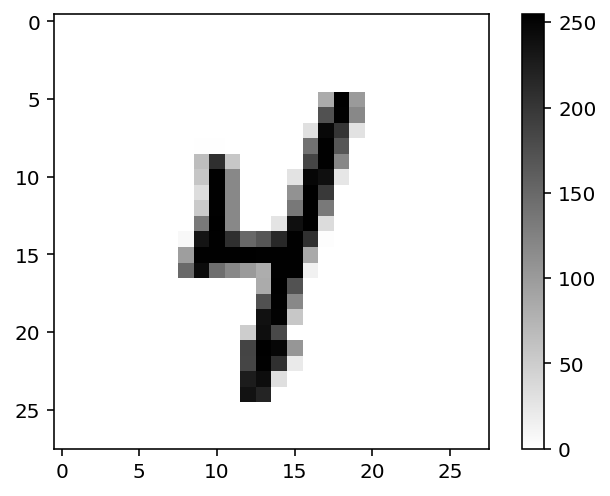

The label of this image is: 4


In [10]:
# Select and visualize a batch of training data.
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.show()

# Print the label to check if consistent and correct
print('The label of this image is:', label)

In [11]:
# Approach 1: Write a class
class My_Network(tf.keras.Model):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.num_classes = num_classes
    
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden_1 = tf.keras.layers.Dense(128, activation = 'relu')
        self.hidden_2 = tf.keras.layers.Dense(64, activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
    
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.output_layer(x)
    
        return x

my_model_2 = My_Network()

my_model_2.build((None, 28, 28, 1))

my_model_2.summary()

Model: "my__network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  100480    
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dense_2 (Dense)             multiple                  650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Clear all the backend sessions
tf.keras.backend.clear_session()

In [13]:
# Approach 2: Use Sequential, should return with the same output as above
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Specify the optimizer, loss function and metrics
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Start to train the model
EPOCHS = 100
history = model.fit(training_batches, epochs = EPOCHS)

Epoch 1/100
938/938 [==============================] - 1s 1ms/step - loss: 0.0346 - accuracy: 0.9887
Epoch 2/100
938/938 [==============================] - 1s 1ms/step - loss: 0.0294 - accuracy: 0.9905
Epoch 3/100
938/938 [==============================] - 1s 1ms/step - loss: 0.0247 - accuracy: 0.9918
Epoch 4/100
938/938 [==============================] - 1s 2ms/step - loss: 0.0201 - accuracy: 0.9933
Epoch 5/100
938/938 [==============================] - 1s 2ms/step - loss: 0.0166 - accuracy: 0.9946
Epoch 6/100
938/938 [==============================] - 1s 1ms/step - loss: 0.0155 - accuracy: 0.9947
Epoch 7/100
938/938 [==============================] - 1s 2ms/step - loss: 0.0151 - accuracy: 0.9948
Epoch 8/100
938/938 [==============================] - 1s 2ms/step - loss: 0.0142 - accuracy: 0.9952
Epoch 9/100
938/938 [==============================] - 1s 1ms/step - loss: 0.0090 - accuracy: 0.9969
Epoch 10/100
938/938 [==============================] - 1s 1ms/step - loss: 0.0122 - accura

In [16]:
# Calculate loss and accuracy after training
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

2/2 [==============================] - 0s 2ms/step - loss: 0.0432 - accuracy: 0.9688

Loss after training: 0.043
Accuracy after training: 96.875%


2/2 [==============================] - 0s 2ms/step


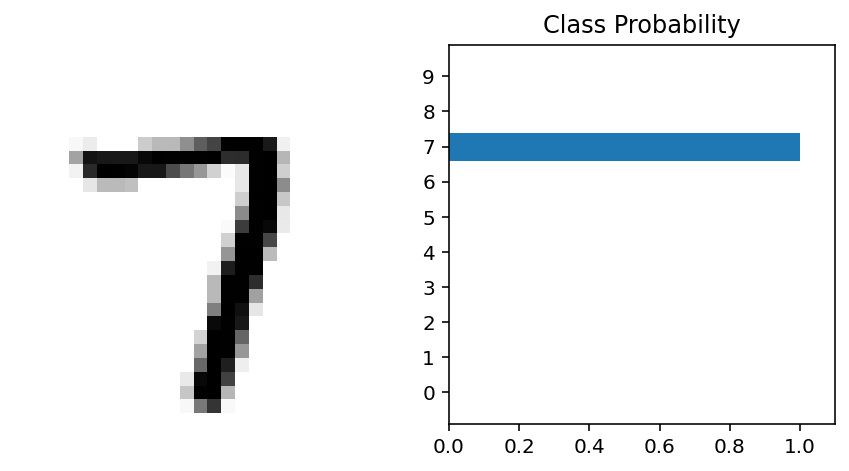

In [18]:
# Test the model
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
  
  
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()